In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def process_image(image_path, output_mask_folder):
    """Process an image to extract spheroid properties and intensity metrics."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print("No contours found")
        return None, None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    # Compute mean intensity inside spheroid
    mean_intensity = np.mean(image[mask == 255])
    
    # Compute intensity variance (heterogeneity)
    intensity_variance = np.var(image[mask == 255])
    
    # Compute radial intensity profile
    cx, cy, w, h = cv2.boundingRect(largest_contour)
    center = (cx + w // 2, cy + h // 2)
    max_radius = max(w, h) // 2
    radial_intensity = []
    
    for r in range(1, max_radius, 2):
        ring_mask = np.zeros_like(image)
        cv2.circle(ring_mask, center, r, 255, thickness=2)
        ring_values = image[(ring_mask == 255) & (mask == 255)]
        if len(ring_values) > 0:
            radial_intensity.append(np.mean(ring_values))
        else:
            radial_intensity.append(0)
    
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_filename = base_name + "_mask.png"
    output_path = os.path.join(output_mask_folder, output_filename)
    cv2.imwrite(output_path, mask)
    
    return mean_intensity, intensity_variance, radial_intensity

In [7]:
def smooth_contour_fourier(contour, num_freqs=20):
    """
    Smooth the given contour using Fourier descriptors, keeping only 'num_freqs' low frequencies.
    Smaller num_freqs => more smoothing; Larger => less smoothing.
    Returns a new array of shape (N,2) for the smoothed contour (float32).
    """
    # Reshape from (N,1,2) to (N,2)
    contour_points = contour.squeeze(axis=1)  # shape: (N,2)
    xs = contour_points[:, 0]
    ys = contour_points[:, 1]

    # Convert to complex: z = x + i*y
    z = xs + 1j*ys
    Z = np.fft.fft(z)
    N = len(Z)

    # Zero out high-frequency components beyond +/- num_freqs
    num_freqs = min(num_freqs, N//2)
    Z[num_freqs : N - num_freqs] = 0

    # Inverse FFT
    z_smooth = np.fft.ifft(Z)

    xs_smooth = np.real(z_smooth)
    ys_smooth = np.imag(z_smooth)

    smoothed_points = np.column_stack((xs_smooth, ys_smooth)).astype(np.float32)
    return smoothed_points

def scale_contour_to_match_area(points, target_area):
    """
    Scales the smoothed contour so that its area matches 'target_area'.
    Steps:
      1) Compute centroid
      2) Measure current area
      3) Scale about centroid by sqrt(target_area / current_area)
    """
    # Compute centroid
    cx = np.mean(points[:,0])
    cy = np.mean(points[:,1])

    # Current area
    c_tmp = points.reshape(-1,1,2).astype(np.float32)
    current_area = cv2.contourArea(c_tmp)
    if current_area < 1e-6:
        return points  # area too small, can't scale meaningfully

    # Scale factor
    scale_factor = np.sqrt(target_area / current_area)

    # Shift to centroid -> scale -> shift back
    pts_shifted = points.copy()
    pts_shifted[:,0] -= cx
    pts_shifted[:,1] -= cy

    pts_scaled = pts_shifted * scale_factor

    pts_scaled[:,0] += cx
    pts_scaled[:,1] += cy

    return pts_scaled

In [8]:
def extract_time_from_filename(filename):
    """Extracts the day and hour from the filename based on naming conventions."""
    try:
        parts = filename.split('_')
        time_part = parts[-1].split('d')
        day = int(time_part[0][-2:])  # Extracts the last two digits before 'd' as day
        hour = int(time_part[1][:2])  # Extracts the two digits after 'd' as hour
        return day, hour
    except:
        return None, None

In [ ]:
def process_condition(folder_path, condition_name):
    """Processes a single condition (folder) and returns aggregated results."""
    results = []
    output_mask_folder = os.path.join(folder_path, "segmented_masks")
    os.makedirs(output_mask_folder, exist_ok=True)

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.png')):
            image_path = os.path.join(folder_path, filename)
            mean_intensity, intensity_variance, radial_intensity = process_image(image_path, output_mask_folder)
            
            if mean_intensity is not None:
                results.append([filename, mean_intensity, intensity_variance, radial_intensity, condition_name])
    
    df = pd.DataFrame(results, columns=["Filename", "Mean Intensity", "Intensity Variance", "Radial Intensity", "Condition"])
    return df

def main(conditions, output_csv):
    """Processes multiple conditions and generates visualizations."""
    all_data = []

    for folder_path, condition_name in conditions.items():
        df_condition = process_condition(folder_path, condition_name)
        all_data.append(df_condition)

    df_all = pd.concat(all_data, ignore_index=True)
    df_all.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

C:\Users\Standard\AppData\Local\Temp\ipykernel_2056\492939833.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Mean Intensity", data=df, palette="Set1")


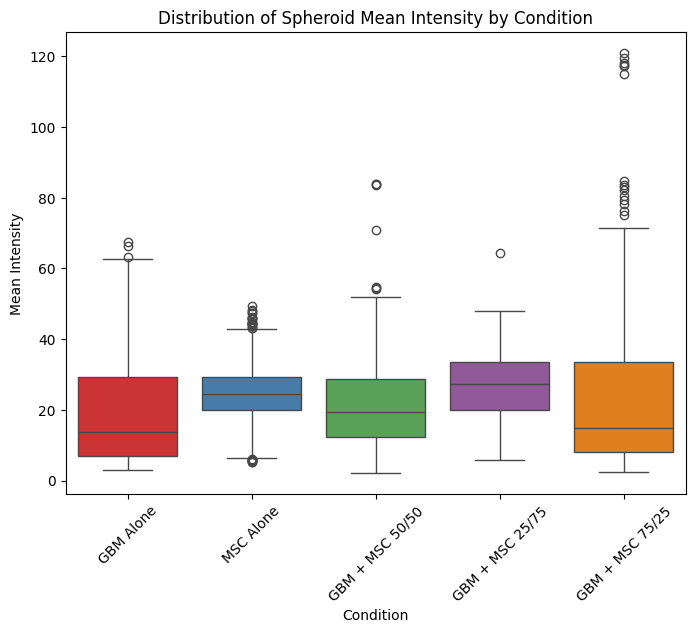

C:\Users\Standard\AppData\Local\Temp\ipykernel_2056\492939833.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Intensity Variance", data=df, palette="Set1")


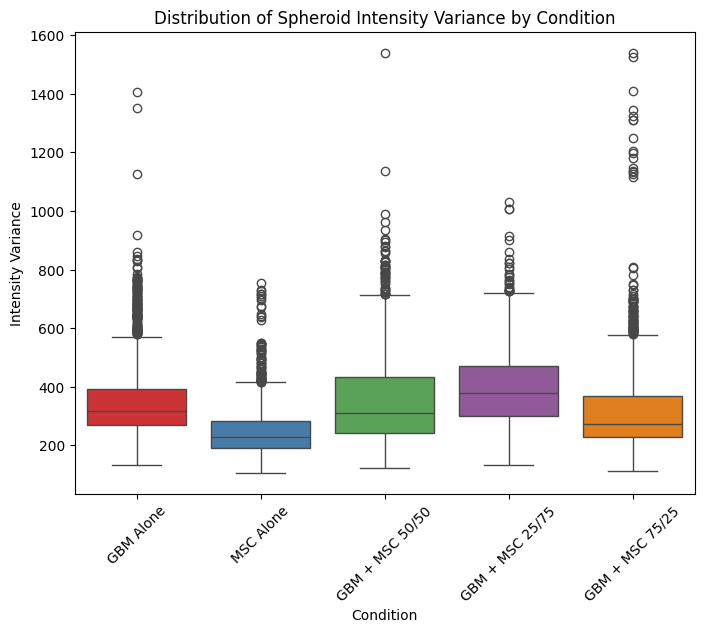

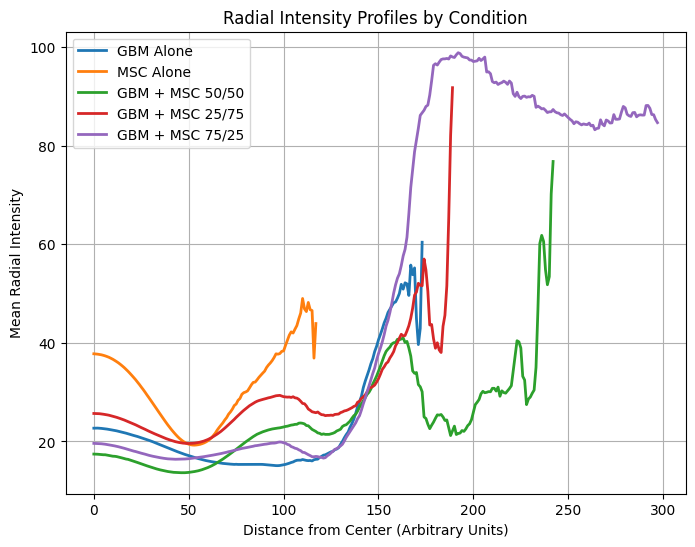

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re  # To clean up the Radial Intensity column

# Load the intensity analysis data
file_path = "../data/experimental_data_analysis/spheroid_intensity_analysis.csv" 
df = pd.read_csv(file_path)

# Function to safely parse "Radial Intensity" column
def parse_radial_intensity(value):
    if isinstance(value, str):
        # Remove `np.float64()` and convert to a proper list of floats
        clean_value = re.sub(r'np\.float64\((.*?)\)', r'\1', value)  
        try:
            return [float(x) for x in clean_value.strip("[]").split(", ")]
        except ValueError:
            return None
    return value  # Return as-is if not a string

# Apply parsing function to Radial Intensity column
if "Radial Intensity" in df.columns:
    df["Radial Intensity"] = df["Radial Intensity"].apply(parse_radial_intensity)

### PLOT 1: Mean Intensity Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Condition", y="Mean Intensity", data=df, palette="Set1")
plt.xticks(rotation=45)
plt.xlabel("Condition")
plt.ylabel("Mean Intensity")
plt.title("Distribution of Spheroid Mean Intensity by Condition")
plt.grid(False)
plt.show()

### PLOT 2: Intensity Variance Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Condition", y="Intensity Variance", data=df, palette="Set1")
plt.xticks(rotation=45)
plt.xlabel("Condition")
plt.ylabel("Intensity Variance")
plt.title("Distribution of Spheroid Intensity Variance by Condition")
plt.grid(False)
plt.show()

### PLOT 3: Mean Intensity Trend Over Time (If Time Available)
if "Time (Days)" in df.columns:
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df, x="Time (Days)", y="Mean Intensity", hue="Condition", marker="o", linewidth=2)
    plt.xlabel("Time (Days)")
    plt.ylabel("Mean Intensity")
    plt.title("Spheroid Mean Intensity Over Time")
    plt.legend()
    plt.grid()
    plt.show()

### PLOT 4: Radial Intensity Profiles (Averaged Per Condition)
if "Radial Intensity" in df.columns:
    plt.figure(figsize=(8, 6))
    for condition in df["Condition"].unique():
        subset = df[df["Condition"] == condition]
        valid_radial = subset["Radial Intensity"].dropna().tolist()
        
        if valid_radial:  # Ensure we have valid data
            avg_radial = pd.DataFrame(valid_radial).mean()  # Average across spheroids
            plt.plot(avg_radial, label=condition, linewidth=2)
    
    plt.xlabel("Distance from Center (Arbitrary Units)")
    plt.ylabel("Mean Radial Intensity")
    plt.title("Radial Intensity Profiles by Condition")
    plt.legend()
    plt.grid()
    plt.show()


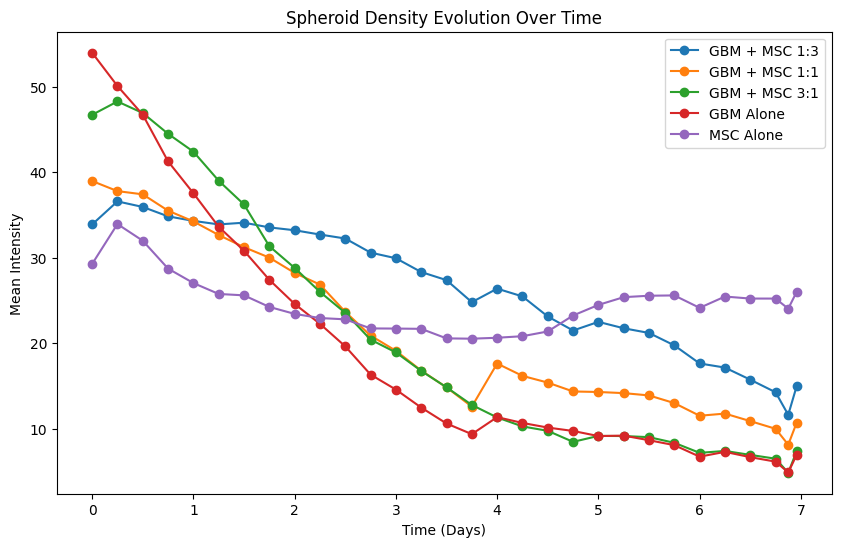

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Load the intensity analysis data
file_path = "spheroid_intensity_analysis.csv"  # Update if needed
df = pd.read_csv(file_path)

# Extract time from filename
def extract_time_from_filename(filename):
    match = re.search(r"(\d+)d(\d+)h", filename)
    if match:
        day = int(match.group(1))
        hour = int(match.group(2))
        return day + hour / 24.0  # Convert to fractional days
    return None

df["Time (Days)"] = df["Filename"].apply(extract_time_from_filename)
label_map = {
    "GBM + MSC 91/9": "GBM + MSC 10:1",
    "GBM + MSC 75/25": "GBM + MSC 3:1",
    "GBM + MSC 50/50": "GBM + MSC 1:1",
    "GBM + MSC 25/75": "GBM + MSC 1:3",
    "GBM + MSC 67/33": "GBM + MSC 2:1",
    "GBM + MSC 83/17": "GBM + MSC 5:1",
    "GBM + MSC 95/5": "GBM + MSC 20:1",
    "GBM Alone": "GBM Alone",
    "MSC Alone": "MSC Alone"
}

# Ensure "Time (Days)" exists
if "Time (Days)" not in df.columns:
    raise KeyError("Column 'Time (Days)' is missing after extraction!")

# Calculate standard deviation (SD) from intensity variance
df["Intensity SD"] = np.sqrt(df["Intensity Variance"])

# Aggregate data: Mean ± SD per condition over time
condition_grouped = df.groupby(["Condition", "Time (Days)"]).agg(
    Mean_Intensity=("Mean Intensity", "mean"),
    SD_Intensity=("Intensity SD", "mean")
).reset_index()

# PLOT: Mean Intensity Over Time with SD
plt.figure(figsize=(10, 6))

for condition in condition_grouped["Condition"].unique():
    subset = condition_grouped[condition_grouped["Condition"] == condition]
    
    # Plot mean intensity with shaded SD region
    label = label_map.get(condition, condition)
    
    plt.plot(subset["Time (Days)"], subset["Mean_Intensity"], label=label, marker="o", linestyle="-")
    """
    plt.fill_between(subset["Time (Days)"], 
                     subset["Mean_Intensity"] - subset["SD_Intensity"], 
                     subset["Mean_Intensity"] + subset["SD_Intensity"], 
                     alpha=0.2)"""

plt.xlabel("Time (Days)")
plt.ylabel("Mean Intensity")
plt.title("Spheroid Density Evolution Over Time")
plt.legend()
plt.grid(False)
plt.show()
